In [26]:
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
df = pd.read_excel('Ferguson.xlsx')
df

D:\Users\aomurbaeva\AppData\Local\anaconda3\envs\ds-course\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,user,tweet,sentiment,"1 - positive, 2 - negative, 3 - neutral"
0,disetv,#stl we war ready #ripmikebrown #ferguson http...,2,NaN
1,deray,one of the best moments from ystrdy was when a...,2,NaN
2,deray,public art. canfield. photo. #ferguson http://...,3,NaN
3,deray,canfield. public art cont. #ferguson http://if...,3,NaN
4,deray,public art exhibit. canfield. #ferguson http:/...,3,NaN
...,...,...,...,...
1201,wuperkins,#ferguson black man telling story of mopping c...,2,NaN
1202,wuperkins,@ryanjreilly very good. now if @govjaynixon wo...,3,NaN
1203,wuperkins,@chucktodd hopefully folks r traveling to #fer...,3,NaN
1204,wuperkins,@wesleylowery hold govt. accountable. #nojusti...,3,NaN


In [27]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\aomurbaeva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Распределение классов:
sentiment
3    646
2    369
1    190
Name: count, dtype: int64


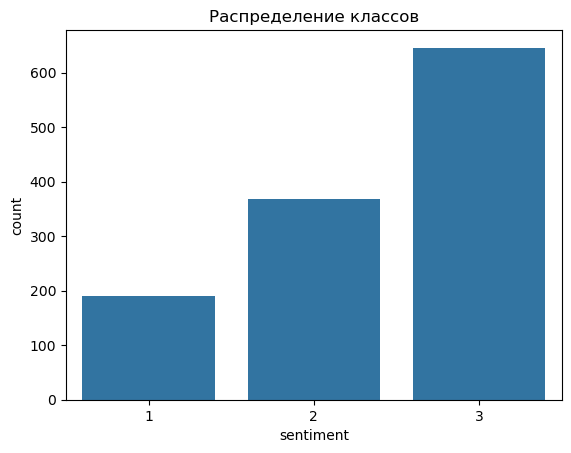

In [28]:
# Удаление пустых значений
df = df.dropna(axis=1, how='all')
df = df.dropna(subset=['tweet', 'sentiment'])

# Оценка сбалансированности классов
print("Распределение классов:")
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df)
plt.title('Распределение классов')
plt.show()

In [29]:
def preprocess_text(text):
    if isinstance(text, str):
        text = text.translate(str.maketrans('', '', string.punctuation))  # Удаление пунктуации
        words = text.split()
        words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]  # Удаление стоп-слов и стемминг
        return ' '.join(words)
    return text

# Применение предобработки
df.loc[:, 'tweet'] = df['tweet'].apply(preprocess_text)

# Проверка данных после предобработки
print("Первые строки данных после предобработки:")
print(df['tweet'].head())

Первые строки данных после предобработки:
0    stl war readi ripmikebrown ferguson httpinstag...
1    one best moment ystrdi protestor quot lil boos...
2    public art canfield photo ferguson httpiftttw1...
3    canfield public art cont ferguson httpifttt1ld...
4    public art exhibit canfield ferguson httpifttt...
Name: tweet, dtype: object


In [30]:
X = df['tweet']
y = df['sentiment']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])

# Определение параметров для Grid Search для SVM
parameters_svm = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [1, 10, 100]
}

# Подбор параметров с помощью Grid Search для SVM
grid_search_svm = GridSearchCV(pipeline_svm, parameters_svm, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted')
grid_search_svm.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid={'clf__C': [1, 10, 100],
                         'clf__kernel': ['linear', 'rbf'],
                         'tfidf__max_df': [0.75, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_weighted', verbose=1)

In [31]:
# Вывод лучших параметров для SVM
print("Лучшие параметры для SVM:")
print(grid_search_svm.best_params_)

# Прогнозирование на тестовой выборке для SVM
y_pred_svm = grid_search_svm.predict(X_test)

# Оценка качества модели для SVM
print("Отчет по классификации для SVM:")
print(classification_report(y_test, y_pred_svm))

Лучшие параметры для SVM:
{'clf__C': 10, 'clf__kernel': 'linear', 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
Отчет по классификации для SVM:
              precision    recall  f1-score   support

           1       0.58      0.55      0.57        38
           2       0.63      0.53      0.57        74
           3       0.72      0.80      0.76       129

    accuracy                           0.68       241
   macro avg       0.64      0.63      0.63       241
weighted avg       0.67      0.68      0.67       241



In [32]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])
parameters_lr = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [1, 10, 100]
}

# Подбор параметров с помощью Grid Search для Логистической Регрессии
grid_search_lr = GridSearchCV(pipeline_lr, parameters_lr, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted')
grid_search_lr.fit(X_train, y_train)

# Вывод лучших параметров для Логистической Регрессии
print("Лучшие параметры для Логистической Регрессии:")
print(grid_search_lr.best_params_)

# Прогнозирование на тестовой выборке для Логистической Регрессии
y_pred_lr = grid_search_lr.predict(X_test)

# Оценка качества модели для Логистической Регрессии
print("Отчет по классификации для Логистической Регрессии:")
print(classification_report(y_test, y_pred_lr))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры для Логистической Регрессии:
{'clf__C': 100, 'tfidf__max_df': 1.0, 'tfidf__ngram_range': (1, 1)}
Отчет по классификации для Логистической Регрессии:
              precision    recall  f1-score   support

           1       0.54      0.58      0.56        38
           2       0.61      0.50      0.55        74
           3       0.70      0.75      0.72       129

    accuracy                           0.65       241
   macro avg       0.61      0.61      0.61       241
weighted avg       0.64      0.65      0.64       241

